# 1. Introduction

**BUSINESS CONTEXT:**
- The Cloudera Data Science Challenge is a rigorous competition in which candidates must provide a solution to a real-world big data problem that surpasses a benchmark specified by some of the world's elite data scientists. In the U.S., Medicare reimburses private providers for medical procedures performed for covered individuals. As such, it needs to verify that the type of procedures performed and the cost of those procedures are consistent and reasonable. Finally, it needs to detect possible errors or fraud in claims for reimbursement from providers. 
- You have been hired to analyze a large amount of data from Medicare and try to detect abnormal data --providers, areas, or patients with unusual procedures and/or claims.The objective of the Cloudera Data Science Challenge 2 was to uncover anomalous patients, procedures, providers, and regions in the United States government’s Medicare health insurance system.

**PROBLEM SUMMARY:**
- The Challenge was divided into the following three parts, each of which had specific requirements that pertained to identifying anomalous entities in different aspects of the Medicare system:  

    - Part 1: Identify providers that overcharge for certain procedures or regions where procedures are too expensive.   
        - 1A: Highest Cost Variation
        - 1B: Highest-Cost Claims by Provider
        - 1C: Highest-Cost Claims by Region
        - 1D: Highest Number of Procedures and Largest Differences between Claims and Reimbursements
        
    - Part 2: Identify the three providers that are least similar to other providers and the three regions that are least similar to other regions. 
        - Part 2A: Providers Least Like Others 
        - Part 2B: Regions Least Like Others
        
    - Part 3: Identify 10,000 Medicare patients who are involved in anomalous activities. 
    
**Submitted By:**
- **_Shriya Jain_**

# 2. Data Prepration

## 2.1 Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## 2.2 Load Data

### 2.2.1 Data For Part-1 and Part-2

In [2]:
drg_inpatient = pd.read_csv('Medicare_Charge_Inpatient_DRG100_DRG_Summary_by_DRG_FY2011.csv')
pd.concat([drg_inpatient.dtypes,drg_inpatient.isna().sum(),drg_inpatient.nunique(),drg_inpatient.iloc[0]],axis=1)

,0,1,2,0
DRG Definition,object,0,100,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC
Total Discharges,int64,0,100,37861
Average Covered Charges,float64,0,100,29228.6
Average Total Payments,float64,0,100,6902.38
Average Medicare Payments,float64,0,100,5514.44


In [3]:
apc_outpatient = pd.read_csv('Medicare_Charge_Outpatient_APC30_Summary_by_APC_CY2011.csv')
pd.concat([apc_outpatient.dtypes,apc_outpatient.isna().sum(),apc_outpatient.nunique(),apc_outpatient.iloc[0]],axis=1)

,0,1,2,0
APC,object,0,30,0012 - Level I Debridement & Destruction
Outpatient Services,int64,0,30,275987
Average Estimated Submitted Charges,float64,0,30,74.203
Average Total Payments,float64,0,30,16.1471


In [4]:
provider_inpatient = pd.read_csv('Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv')
pd.concat([provider_inpatient.dtypes,provider_inpatient.isna().sum(),provider_inpatient.nunique(),provider_inpatient.iloc[0]],axis=1).sort_values(by=[2])

,0,1,2,0
Provider State,object,0,51,AL
DRG Definition,object,0,100,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC
Hospital Referral Region (HRR) Description,object,0,306,AL - Dothan
Total Discharges,int64,0,642,91
Provider City,object,0,1977,DOTHAN
Provider Zip Code,int64,0,3053,36301
Provider Name,object,0,3201,SOUTHEAST ALABAMA MEDICAL CENTER
Provider Street Address,object,0,3326,1108 ROSS CLARK CIRCLE
Provider Id,int64,0,3337,10001
Average Total Payments,float64,0,154891,5777.24


In [5]:
provider_outpatient = pd.read_csv('Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv')
pd.concat([provider_outpatient.dtypes,provider_outpatient.isna().sum(),provider_outpatient.nunique(),provider_outpatient.iloc[0]],axis=1).sort_values(by=[2])
provider_outpatient.rename(columns={'Average  Estimated Submitted Charges':'Average Estimated Submitted Charges'},inplace=True)

,0,1,2,0
APC,object,0,30,0012 - Level I Debridement & Destruction
Provider State,object,0,50,AL
Hospital Referral Region (HRR) Description,object,0,304,AL - Birmingham
Provider City,object,0,1899,OPELIKA
Provider Zip Code,int64,0,2897,36801
Provider Name,object,0,3007,EAST ALABAMA MEDICAL CENTER AND SNF
Provider Street Address,object,0,3124,2000 PEPPERELL PARKWAY
Provider Id,int64,0,3135,10029
Outpatient Services,int64,0,3394,23
Average Total Payments,float64,0,35536,21.9104


### 2.2.2 Data for Part-3

In [6]:
patient_history = pd.read_csv('Patient_history_samp.csv')
df = patient_history
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
patient_history.shape

,0,1,2,0
gender,object,0.0000,2,F
age,object,0.5060,4,65-74
income,object,0.5062,5,24000-31999
id,int64,0.0000,500000,306535165


(500000, 4)

In [7]:
patient_history.dropna(inplace=True)

In [8]:
patient_history.isna().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [9]:
review = pd.read_csv('Review_patient_history_samp.csv')
df = review
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
df.shape

,0,1,2,0
gender,object,0.00,2,F
age,object,0.52,4,65-74
income,object,0.52,5,24000-31999
id,int64,0.00,5000,381693273


(5000, 4)

In [10]:
review.dropna(inplace=True)

In [11]:
review.isna().sum()

id        0
age       0
gender    0
income    0
dtype: int64

In [12]:
transaction_coo = pd.read_csv('Transaction_coo.csv')
df = transaction_coo
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
transaction_coo.shape

,0,1,2,0
count,int64,0.0,1,1
global_proc_id,int64,0.0,130,1
id,int64,0.0,505000,159125


(1514809, 3)

In [13]:
fraudulent_transaction = pd.read_csv('Rreview_transaction_coo.csv')
df = fraudulent_transaction
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
df.shape

,0,1,2,0
count,int64,0.0,1,1
global_proc_id,int64,0.0,129,109
id,int64,0.0,5000,65822


(15041, 3)

# 3 Identify providers that overcharge for certain procedures or regions where procedures are too expensive

In [14]:
inpatient = pd.merge(provider_inpatient,drg_inpatient,how='inner',on='DRG Definition',suffixes=(' Provider', ''))
inpatient.head(2)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges Provider,Average Covered Charges Provider,Average Total Payments Provider,Average Medicare Payments Provider,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07692,5777.241758,4763.736264,37861,29228.55368,6902.381289,5514.43591
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85714,5787.571429,4976.714286,37861,29228.55368,6902.381289,5514.43591


In [15]:
outpatient = pd.merge(provider_outpatient,apc_outpatient,how='inner',on='APC',suffixes=(' Provider', ''))
outpatient.head(2)

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services Provider,Average Estimated Submitted Charges Provider,Average Total Payments Provider,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
0,0012 - Level I Debridement & Destruction,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,23,78.086957,21.910435,275987,74.202956,16.147079
1,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853,275987,74.202956,16.147079


## 3.1 Highest Cost Variation

### 3.1.1 Identify providers that overcharge for certain procedures

In [16]:
temp = outpatient.groupby(by=['Provider Name','APC']).agg({'Average Estimated Submitted Charges Provider':['std','mean']})
temp.columns = ['Average Estimated Submitted Charges Provider_std','Average Estimated Submitted Charges Provider_mean']
temp['Average Estimated Submitted Charges Provider_cv'] = temp['Average Estimated Submitted Charges Provider_std']/temp['Average Estimated Submitted Charges Provider_mean']
pd.DataFrame(temp['Average Estimated Submitted Charges Provider_cv'].sort_values(ascending=False)[:3]).reset_index()['Provider Name']

0         ST JOSEPH HOSPITAL
1    MARION GENERAL HOSPITAL
2          MEMORIAL HOSPITAL
Name: Provider Name, dtype: object

### 3.1.2 Regions where procedures are too expensive.

In [17]:
temp = outpatient.groupby(by=['Hospital Referral Region (HRR) Description','APC']).agg({'Average Estimated Submitted Charges Provider':['std','mean']})
temp.columns = ['Average Estimated Submitted Charges Provider_std','Average Estimated Submitted Charges Provider_mean']
temp['Average Estimated Submitted Charges Provider_cv'] = temp['Average Estimated Submitted Charges Provider_std']/temp['Average Estimated Submitted Charges Provider_mean']
pd.DataFrame(temp['Average Estimated Submitted Charges Provider_cv'].sort_values(ascending=False)[:3]).reset_index()['Hospital Referral Region (HRR) Description']

0    PA - Philadelphia
1      AL - Birmingham
2      IN - South Bend
Name: Hospital Referral Region (HRR) Description, dtype: object

## 3.2 Highest-Cost Claims by Provider

    -  Which three providers claimed the highest amount(on average) for the largest number of procedures?


In [18]:
temp1 = outpatient.sort_values(by=['APC','Average Estimated Submitted Charges'],ascending=[False,False]).groupby(['APC']).head()
temp2 = temp1['Provider Name'].value_counts().sort_values(ascending=False)[:3]
temp2

SOUTHEAST ALABAMA MEDICAL CENTER    23
MARSHALL MEDICAL CENTER SOUTH       18
ELIZA COFFEE MEMORIAL HOSPITAL      17
Name: Provider Name, dtype: int64

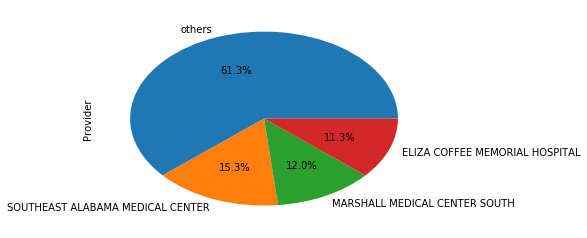

In [19]:
temp3 = pd.DataFrame(np.where(temp1['Provider Name'].isin(temp2.index),temp1['Provider Name'],'others'))
temp3.columns = ['Provider']
temp3['Provider'].value_counts().plot(kind='pie', autopct='%1.1f%%')

## 3.3 Highest-Cost Claims by Region
    - The three regions claimed the highest average amount for the largest number of procedures?

In [20]:
temp1 = outpatient.sort_values(by=['APC','Average Estimated Submitted Charges'],ascending=[False,False]).groupby(['APC']).head()
temp2= temp1['Hospital Referral Region (HRR) Description'].value_counts().sort_values(ascending=False)[:3]
temp2

AL - Birmingham    67
AL - Dothan        35
AL - Montgomery    14
Name: Hospital Referral Region (HRR) Description, dtype: int64

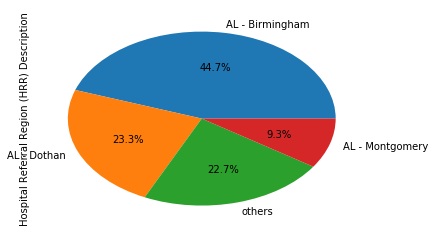

In [21]:
temp3 = pd.DataFrame(np.where(temp1['Hospital Referral Region (HRR) Description'].isin(temp2.index),temp1['Hospital Referral Region (HRR) Description'],'others'))
temp3.columns = ['Hospital Referral Region (HRR) Description']
temp3['Hospital Referral Region (HRR) Description'].value_counts().plot(kind='pie', autopct='%1.1f%%')

## 3.4 Highest Number of Procedures and Largest Differences between Claims and Reimbursements

    - Which three providers had the largest claim difference for the largest number of procedures?

In [22]:
temp = pd.DataFrame(outpatient[['APC','Provider Name','Average Estimated Submitted Charges Provider','Average Total Payments Provider']])
temp['Claim_diff'] = temp['Average Estimated Submitted Charges Provider']-temp['Average Total Payments Provider']
temp1 = temp.sort_values(by=['APC','Claim_diff'],ascending=[False,False]).groupby(['APC']).head()
temp2 = temp1['Provider Name'].value_counts().sort_values(ascending=False)[:3]
temp2

CAPITAL HEALTH MEDICAL CENTER - HOPEWELL    4
CAPITAL HEALTH SYSTEM-FULD CAMPUS           4
JENNERSVILLE REGIONAL HOSPITAL              4
Name: Provider Name, dtype: int64

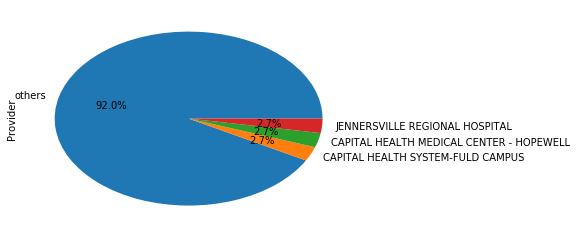

In [23]:
temp3 = pd.DataFrame(np.where(temp1['Provider Name'].isin(temp2.index),temp1['Provider Name'],'others'))
temp3.columns = ['Provider']
temp3['Provider'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# 4 Least like others

In [24]:
# Unique category labels:
color_labels = range(26)

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 26)

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

## 4.1 Providers least like others

### 4.1.1 For inpatient services

In [25]:
provider_inpatient2 = pd.DataFrame(data=provider_inpatient[['Provider Name','Total Discharges','Average Covered Charges','Average Total Payments','Average Medicare Payments']])

In [26]:
provider_inpatient2 = provider_inpatient2.groupby('Provider Name').mean()

In [27]:
data = provider_inpatient2.astype(np.float)
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [28]:
for K in range(1,15):
    kmeans_model = KMeans(n_clusters=K,random_state=50).fit(data)
    centers = np.array(kmeans_model.cluster_centers_)
    labels = pd.Series(kmeans_model.labels_)
    print('*'*10)
    print(K)
    print(labels.value_counts().sort_values()[:3])

**********
1
0    3201
dtype: int64
**********
2
0     904
1    2297
dtype: int64
**********
3
2       1
0     960
1    2240
dtype: int64
**********
4
2       1
3     377
0    1348
dtype: int64
**********
5
1      1
4    235
0    430
dtype: int64
**********
6
5      1
4     35
1    231
dtype: int64
**********
7
2     1
3    36
4    78
dtype: int64
**********
8
2     1
7     2
5    35
dtype: int64
**********
9
2     1
7     2
5    35
dtype: int64
**********
10
2     1
7     2
5    34
dtype: int64
**********
11
6      1
9      2
10    21
dtype: int64
**********
12
4     1
8     2
6    21
dtype: int64
**********
13
4     1
12    2
5     3
dtype: int64
**********
14
3    1
8    2
6    3
dtype: int64


In [29]:
kmeans_model = KMeans(n_clusters=8,random_state=50).fit(data)
labels = pd.Series(kmeans_model.labels_)
labels.index = provider_inpatient2.index
provider_inpatient2['labels'] = labels

In [30]:
provider_inpatient2['labels'].value_counts().sort_values()

2       1
7       2
5      35
3     126
0     367
4     370
6    1127
1    1173
Name: labels, dtype: int64

In [31]:
to_plot2 = provider_inpatient2[provider_inpatient2['labels'].isin(provider_inpatient2['labels'].value_counts().sort_values()[:2].index)]
to_plot2.index

Index([u'ADCARE HOSPITAL OF WORCESTER INC', u'UVA HEALTH SCIENCES CENTER',
       u'VAIL VALLEY MEDICAL CENTER'],
      dtype='object', name=u'Provider Name')

Providers least like others for inpatient services are :
    - ADCARE HOSPITAL OF WORCESTER INC
    - UVA HEALTH SCIENCES CENTER
    - VAIL VALLEY MEDICAL CENTER

In [32]:
to_plot = provider_inpatient2[provider_inpatient2['labels'].isin(provider_inpatient2['labels'].value_counts().sort_values().index)]

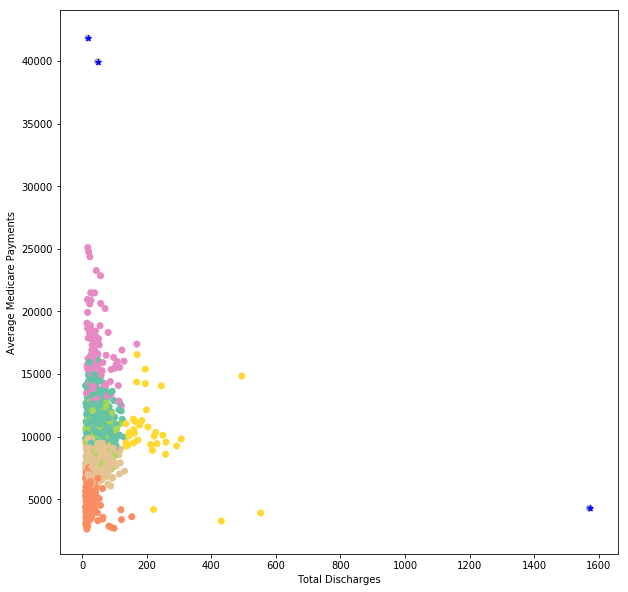

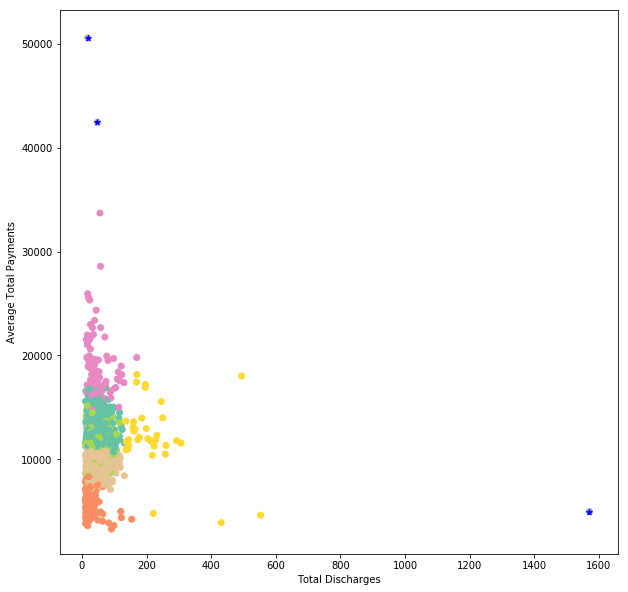

In [33]:
for x,y  in [('Total Discharges', 'Average Medicare Payments'),('Total Discharges', 'Average Total Payments')]:
    fig, ax = plt.subplots(figsize=(10,10)) 
    tmp = plt.scatter(x=to_plot[x],y=to_plot[y],c=to_plot['labels'].map(color_map))
    tmp = plt.scatter(x=to_plot2[x],y=to_plot2[y],c='b',marker='*')
    tmp = plt.xlabel(x)
    tmp = plt.ylabel(y)
    plt.show()

### 4.1.2 For outpatient services

In [34]:
provider_outpatient2 = pd.DataFrame(data=provider_outpatient[['Provider Name','Outpatient Services','Average Estimated Submitted Charges','Average Total Payments']])

In [35]:
provider_outpatient2 = provider_outpatient2.groupby('Provider Name').mean()

In [36]:
data = provider_outpatient2.astype(np.float)
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [37]:
for K in range(1,15):
    kmeans_model = KMeans(n_clusters=K,random_state=50).fit(data)
    centers = np.array(kmeans_model.cluster_centers_)
    labels = pd.Series(kmeans_model.labels_)
    print('*'*10)
    print(K)
    print(labels.value_counts().sort_values()[:3])

**********
1
0    3007
dtype: int64
**********
2
0     834
1    2173
dtype: int64
**********
3
2      89
0     774
1    2144
dtype: int64
**********
4
1      89
2     248
3    1284
dtype: int64
**********
5
2     89
0    199
3    473
dtype: int64
**********
6
5     39
1    153
2    198
dtype: int64
**********
7
4     25
6     63
0    118
dtype: int64
**********
8
2     38
4     43
6    141
dtype: int64
**********
9
8     4
6    40
3    54
dtype: int64
**********
10
7     4
0    42
2    54
dtype: int64
**********
11
8     4
9    22
2    51
dtype: int64
**********
12
10     2
6     20
4     33
dtype: int64
**********
13
10     2
2     20
3     26
dtype: int64
**********
14
12    2
13    6
11    7
dtype: int64


In [38]:
kmeans_model = KMeans(n_clusters=9,random_state=50).fit(data)
labels = pd.Series(kmeans_model.labels_)
labels.index = provider_outpatient2.index
provider_outpatient2['labels'] = labels

In [39]:
to_plot2 = provider_outpatient2[provider_outpatient2['labels'].isin(provider_outpatient2['labels'].value_counts().sort_values()[:1].index)].sort_values(by=['labels'])
to_plot2.index

Index([u'CLEVELAND CLINIC', u'EVANSTON HOSPITAL', u'LAHEY CLINIC HOSPITAL',
       u'SCOTT & WHITE MEMORIAL HOSPITAL'],
      dtype='object', name=u'Provider Name')

Providers least like others for outpatient services are :
    - CLEVELAND CLINIC
    - EVANSTON HOSPITAL
    - LAHEY CLINIC HOSPITAL
    - SCOTT & WHITE MEMORIAL HOSPITAL

In [40]:
to_plot = provider_outpatient2[provider_outpatient2['labels'].isin(provider_outpatient2['labels'].value_counts().sort_values().index)]

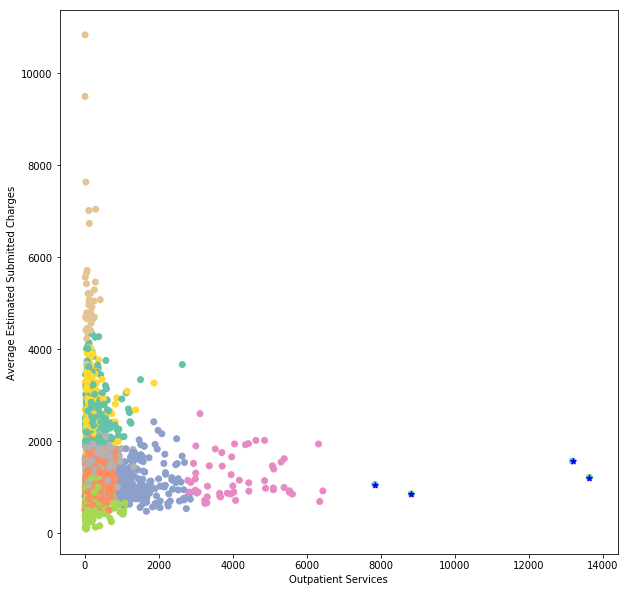

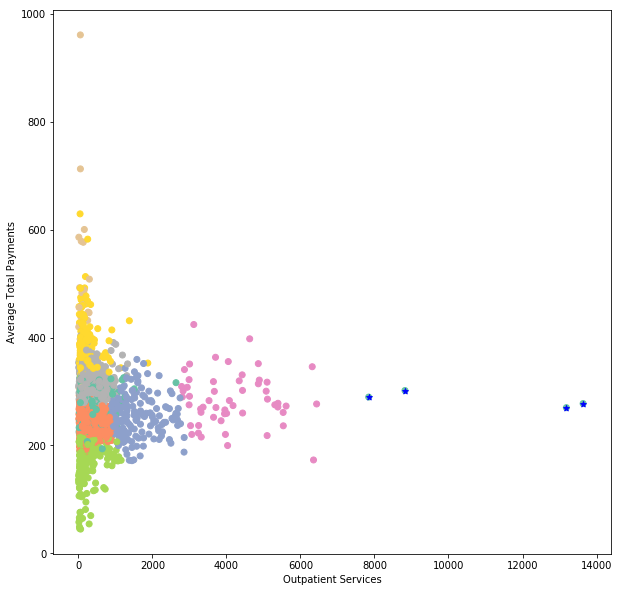

In [41]:
for x,y  in [('Outpatient Services', 'Average Estimated Submitted Charges'),('Outpatient Services', 'Average Total Payments')]:
    fig, ax = plt.subplots(figsize=(10,10)) 
    tmp = plt.scatter(x=to_plot[x],y=to_plot[y],c=to_plot['labels'].map(color_map))
    tmp = plt.scatter(x=to_plot2[x],y=to_plot2[y],c='b',marker='*')
    tmp = plt.xlabel(x)
    tmp = plt.ylabel(y)
    plt.show()

## 4.2 Regions Least Like Others
    

### 4.2.1 For inpatient services

In [42]:
region_inpatient = pd.DataFrame(data=provider_inpatient[['Hospital Referral Region (HRR) Description','Total Discharges','Average Covered Charges','Average Total Payments','Average Medicare Payments']])

In [43]:
region_inpatient = region_inpatient.groupby('Hospital Referral Region (HRR) Description').mean()

In [44]:
data = region_inpatient.astype(np.float)
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [45]:
for K in range(1,15):
    kmeans_model = KMeans(n_clusters=K,random_state=50).fit(data)
    centers = np.array(kmeans_model.cluster_centers_)
    labels = pd.Series(kmeans_model.labels_)
    print('*'*10)
    print(K)
    print(labels.value_counts().sort_values()[:3])

**********
1
0    306
dtype: int64
**********
2
0     49
1    257
dtype: int64
**********
3
2     44
0     64
1    198
dtype: int64
**********
4
2    21
3    59
1    64
dtype: int64
**********
5
2     9
4    36
3    36
dtype: int64
**********
6
2     9
4    27
3    31
dtype: int64
**********
7
4    15
5    20
2    20
dtype: int64
**********
8
2     6
1    15
4    24
dtype: int64
**********
9
3     3
5     6
8    18
dtype: int64
**********
10
9     2
2     7
3    17
dtype: int64
**********
11
9     2
5     7
7    18
dtype: int64
**********
12
11     2
6      6
0     10
dtype: int64
**********
13
11    2
1     6
12    7
dtype: int64
**********
14
11    2
3     6
0     8
dtype: int64


In [46]:
kmeans_model = KMeans(n_clusters=5,random_state=50).fit(data)
labels = pd.Series(kmeans_model.labels_)
labels.index = region_inpatient.index
region_inpatient['labels'] = labels

In [47]:
to_plot2 = region_inpatient[region_inpatient['labels'].isin(region_inpatient['labels'].value_counts().sort_values()[:1].index)].sort_values(by=['labels'])
to_plot2.index

Index([u'AK - Anchorage', u'CA - Alameda County', u'CA - Contra Costa County',
       u'CA - Salinas', u'CA - San Francisco', u'CA - San Jose',
       u'CA - San Mateo County', u'NY - Bronx', u'NY - Manhattan'],
      dtype='object', name=u'Hospital Referral Region (HRR) Description')

Regions least like others for inpatient services :
    - AK - Anchorage
    - CA - Alameda County
    - CA - Contra Costa County
    - CA - Salinas
    - CA - San Francisco
    - CA - San Jose
    - CA - San Mateo County
    - NY - Bronx
    - NY - Manhattan

In [48]:
to_plot = region_inpatient[region_inpatient['labels'].isin(region_inpatient['labels'].value_counts().sort_values().index)]

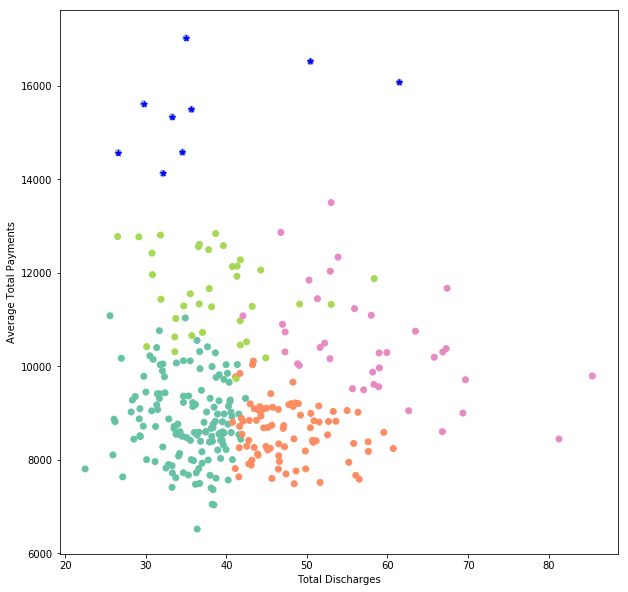

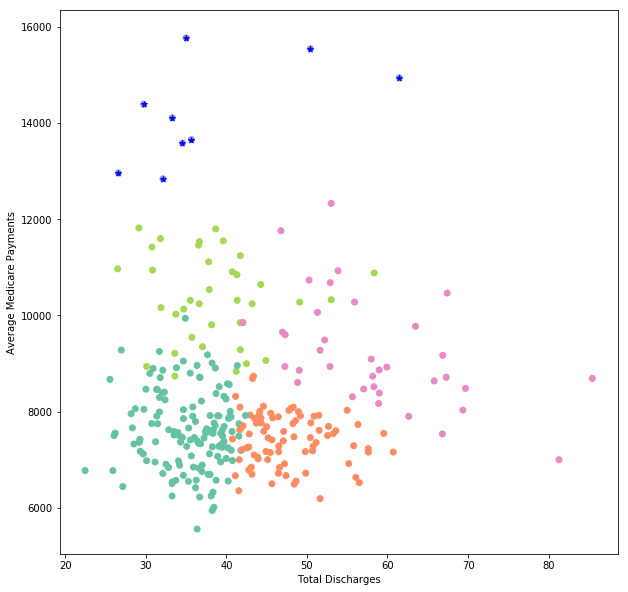

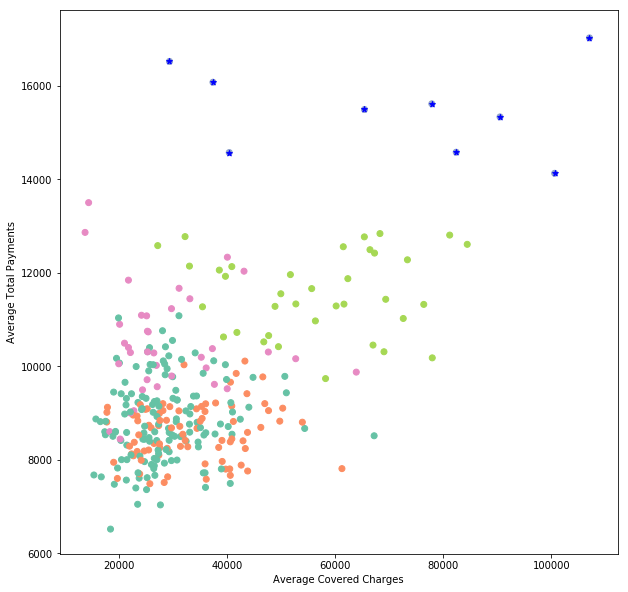

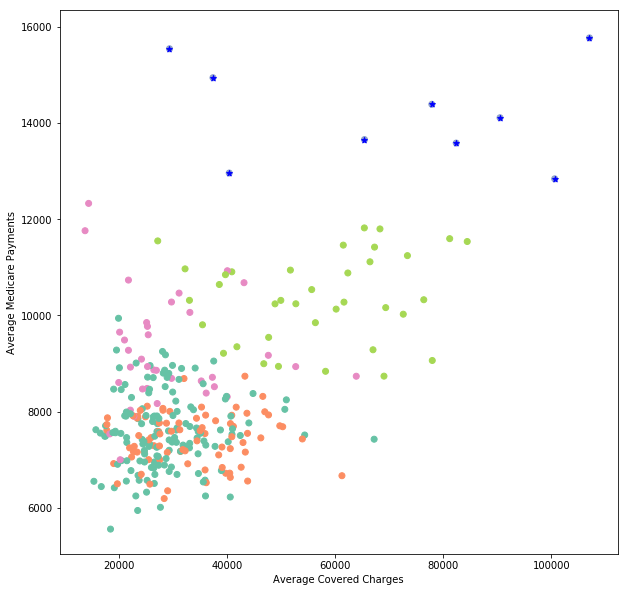

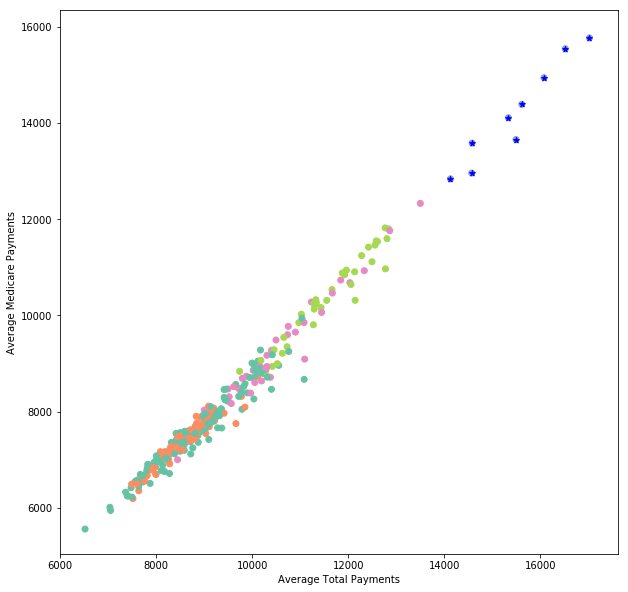

In [49]:
for x,y  in [('Total Discharges', 'Average Total Payments'),
 ('Total Discharges', 'Average Medicare Payments'),
 ('Average Covered Charges', 'Average Total Payments'),
 ('Average Covered Charges', 'Average Medicare Payments'),
 ('Average Total Payments', 'Average Medicare Payments')]:
    fig, ax = plt.subplots(figsize=(10,10)) 
    tmp = plt.scatter(x=to_plot[x],y=to_plot[y],c=to_plot['labels'].map(color_map))
    tmp = plt.scatter(x=to_plot2[x],y=to_plot2[y],c='b',marker='*')
    tmp = plt.xlabel(x)
    tmp = plt.ylabel(y)
    plt.show()

### 4.2.2 For outpatient services

In [50]:
region_outpatient = pd.DataFrame(data=provider_outpatient[['Hospital Referral Region (HRR) Description','Outpatient Services','Average Estimated Submitted Charges','Average Total Payments']])

In [51]:
region_outpatient = region_outpatient.groupby('Hospital Referral Region (HRR) Description').mean()

In [52]:
data = region_outpatient.astype(np.float)
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [53]:
for K in range(1,15):
    kmeans_model = KMeans(n_clusters=K,random_state=50).fit(data)
    centers = np.array(kmeans_model.cluster_centers_)
    labels = pd.Series(kmeans_model.labels_)
    print('*'*10)
    print(K)
    print(labels.value_counts().sort_values()[:3])

**********
1
0    304
dtype: int64
**********
2
1     91
0    213
dtype: int64
**********
3
2      1
1     79
0    224
dtype: int64
**********
4
3     1
0    72
2    77
dtype: int64
**********
5
4     1
0    38
2    58
dtype: int64
**********
6
3     1
5    22
1    31
dtype: int64
**********
7
5     1
3    20
2    27
dtype: int64
**********
8
7     1
0     2
4    25
dtype: int64
**********
9
2     1
8     2
7    20
dtype: int64
**********
10
6     1
2     2
8    20
dtype: int64
**********
11
3      1
9      2
10    15
dtype: int64
**********
12
3      1
5      2
11    12
dtype: int64
**********
13
2     1
8     2
11    3
dtype: int64
**********
14
2     1
5     2
12    3
dtype: int64


In [54]:
kmeans_model = KMeans(n_clusters=8,random_state=50).fit(data)
labels = pd.Series(kmeans_model.labels_)
labels.index = region_outpatient.index
region_outpatient['labels'] = labels

In [55]:
to_plot2 = region_outpatient[region_outpatient['labels'].isin(region_outpatient['labels'].value_counts().sort_values()[:2].index)].sort_values(by=['labels'])
to_plot2.index

Index([u'ND - Grand Forks', u'NH - Lebanon', u'TX - Temple'], dtype='object', name=u'Hospital Referral Region (HRR) Description')

Regions least like others for outpatient services :
    - ND - Grand Forks
    - NH - Lebanon
    - TX - Temple

In [56]:
to_plot = region_outpatient[region_outpatient['labels'].isin(region_outpatient['labels'].value_counts().sort_values().index)]

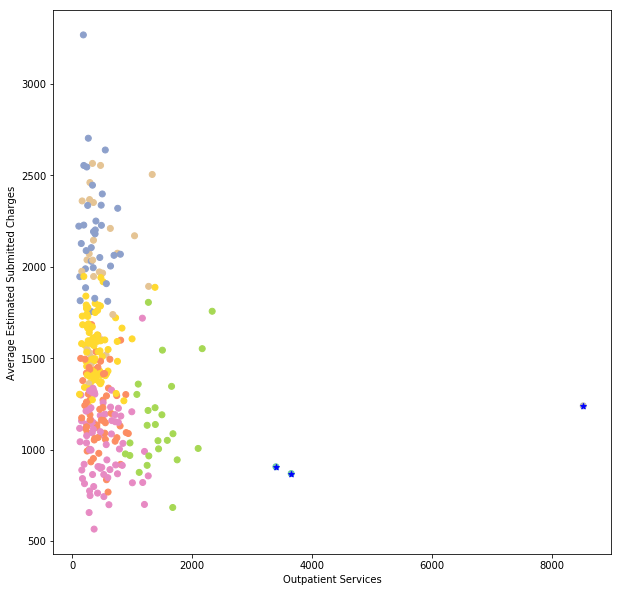

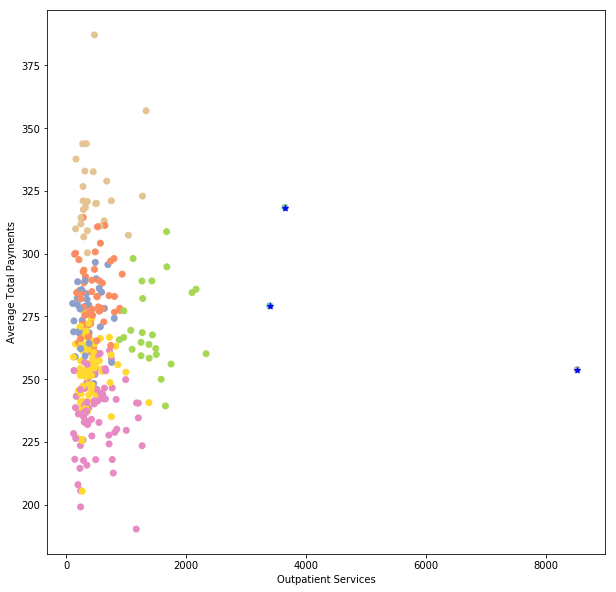

In [57]:
for y,x  in [('Average Estimated Submitted Charges', 'Outpatient Services'),
 ('Average Total Payments', 'Outpatient Services')]:
    fig, ax = plt.subplots(figsize=(10,10)) 
    tmp = plt.scatter(x=to_plot[x],y=to_plot[y],c=to_plot['labels'].map(color_map))
    tmp = plt.scatter(x=to_plot2[x],y=to_plot2[y],c='b',marker='*')
    tmp = plt.xlabel(x)
    tmp = plt.ylabel(y)
    plt.show()

# 5  Identify 10,000 Medicare patients who are involved in anomalous activities

In [58]:
df = patient_history
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
patient_history.shape

df = review
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
df.shape

,0,1,2,0
gender,object,0.0,2,F
age,object,0.0,4,65-74
income,object,0.0,5,24000-31999
id,int64,0.0,494951,306535165


(494951, 4)

,0,1,2,0
gender,object,0.0,2,F
age,object,0.0,4,65-74
income,object,0.0,5,24000-31999
id,int64,0.0,4948,381693273


(4948, 4)

In [59]:
patient_history.id.isin(review.id).sum()
patient_history.nunique()
review.nunique()

0

id        494951
age            4
gender         2
income         5
dtype: int64

id        4948
age          4
gender       2
income       5
dtype: int64

In [60]:
# Merging Patient_history and review , and creating review flag to identify patients who have been reviewed
patient_history = pd.concat([patient_history,review],axis=0).reset_index()
patient_history.drop(columns=['index'],inplace=True)
patient_history['REVIEW_FLAG']  = np.where(patient_history.id.isin(review.id),1,0)

In [61]:
patient_history.index.duplicated().sum()

0

In [62]:
# Converting age and income to ordinal variables
# Converting gender to binary variable
patient_history['age'].unique()
patient_history['income'].unique()
patient_history['gender'].unique()

array(['65-74', '75-84', '<65', '85+'], dtype=object)

array(['24000-31999', '48000+', '32000-47999', '<16000', '16000-23999'],
      dtype=object)

array(['F', 'M'], dtype=object)

In [63]:
age_map = {'65-74':1, '75-84':2, '<65':0, '85+':3}
income_map = {'24000-31999':2, '48000+':4, '32000-47999':3, '<16000':0, '16000-23999':1}
gender_map = {'F':0,'M':1}

patient_history['age']  = patient_history['age'].map(age_map)
patient_history['income'] = patient_history['income'].map(income_map)
patient_history['gender'] = patient_history['gender'].map(gender_map)

In [64]:
patient_history.head(2)

,id,age,gender,income,REVIEW_FLAG
0,306535165,1,0,2,0
1,742231134,1,0,4,0


In [65]:
# Scaling data to apply kmeans later
patient_history_std = pd.DataFrame(StandardScaler().fit_transform(patient_history[['age','income','gender']].astype(float)))
patient_history_std.columns = ['age','income','gender']
patient_history_std.isna().sum()

age       0
income    0
gender    0
dtype: int64

In [66]:
df = transaction_coo
pd.concat([df.dtypes,(df.isna().sum()/df.shape[0])*100,df.nunique(),df.iloc[0]],axis=1).sort_values(by=[2])
df.shape

,0,1,2,0
count,int64,0.0,1,1
global_proc_id,int64,0.0,130,1
id,int64,0.0,505000,159125


(1514809, 3)

In [67]:
def create_dummies(df,col):
    df_dum = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df,df_dum],axis=1)
    return(df)

In [68]:
# One hot encoding the global_proc_id
dumpro = pd.DataFrame(transaction_coo[['global_proc_id']])
dum_cols = ['global_proc_id']
for col in dum_cols:
    dumpro = create_dummies(dumpro,col)

In [69]:
dumpro.head(2)

,global_proc_id,global_proc_id_1,global_proc_id_2,global_proc_id_3,global_proc_id_4,global_proc_id_5,global_proc_id_6,global_proc_id_7,global_proc_id_8,global_proc_id_9,...,global_proc_id_121,global_proc_id_122,global_proc_id_123,global_proc_id_124,global_proc_id_125,global_proc_id_126,global_proc_id_127,global_proc_id_128,global_proc_id_129,global_proc_id_130
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
# Performing Truncated Singular Value Decomposition on dumpro to reduce dimensions
data=dumpro.iloc[:,1:]
svd = TruncatedSVD(n_components=10,random_state=50)
svdpro=svd.fit(data)
svdpro

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=50, tol=0.0)

In [71]:
data.isna().sum().sort_values(ascending=False).head()

global_proc_id_130    0
global_proc_id_33     0
global_proc_id_35     0
global_proc_id_36     0
global_proc_id_37     0
dtype: int64

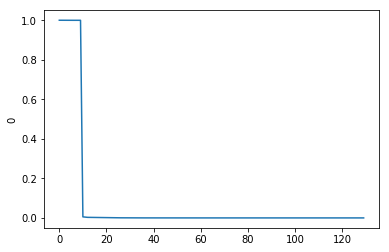

In [72]:
# Absolute sum of loading for each binary variable
sns.lineplot(x=pd.DataFrame(svdpro.components_).abs().sum().sort_values(ascending=False).reset_index().index ,y=pd.DataFrame(svdpro.components_).abs().sum().sort_values(ascending=False).reset_index()[0])

In [73]:
# Selecting 10 binary variables which have loadings sum greater than zero
proc_id = pd.DataFrame(svdpro.components_).abs().sum().sort_values(ascending=False)[:10].index
proc_id

Int64Index([19, 21, 33, 12, 27, 18, 16, 26, 24, 25], dtype='int64')

In [74]:
svd_dum_col = [col for col in dumpro.columns if col != 'global_proc_id' and int(col.split('_')[3]) in proc_id]
svd_dum_col.append('global_proc_id')
svd_dum_col

['global_proc_id_12',
 'global_proc_id_16',
 'global_proc_id_18',
 'global_proc_id_19',
 'global_proc_id_21',
 'global_proc_id_24',
 'global_proc_id_25',
 'global_proc_id_26',
 'global_proc_id_27',
 'global_proc_id_33',
 'global_proc_id']

In [75]:
patient_history.head(2)
patient_history.shape
patient_history.isna().sum()
patient_history_std.head(2)
patient_history_std.shape
patient_history_std.isna().sum()

,id,age,gender,income,REVIEW_FLAG
0,306535165,1,0,2,0
1,742231134,1,0,4,0


(499899, 5)

id             0
age            0
gender         0
income         0
REVIEW_FLAG    0
dtype: int64

,age,income,gender
0,-0.383535,-0.013522,-0.906123
1,-0.383535,1.336348,-0.906123


(499899, 3)

age       0
income    0
gender    0
dtype: int64

In [76]:
patient_history_std['id'] = patient_history['id']

In [77]:
patient_history.head(2)
patient_history_std.head(2)

,id,age,gender,income,REVIEW_FLAG
0,306535165,1,0,2,0
1,742231134,1,0,4,0


,age,income,gender,id
0,-0.383535,-0.013522,-0.906123,306535165
1,-0.383535,1.336348,-0.906123,742231134


In [78]:
svdpro2 = dumpro.loc[:,svd_dum_col]
svdpro2['id'] = transaction_coo['id']
svdpro2.head(2)

,global_proc_id_12,global_proc_id_16,global_proc_id_18,global_proc_id_19,global_proc_id_21,global_proc_id_24,global_proc_id_25,global_proc_id_26,global_proc_id_27,global_proc_id_33,global_proc_id,id
0,0,0,0,0,0,0,0,0,0,0,1,159125
1,0,0,0,0,0,0,0,0,0,0,1,191852


In [79]:
# merging patient data and selected binary variables from transaction data over id 
patient_history_std = pd.merge(patient_history_std,svdpro2,on='id')

In [80]:
patient_history_std.head(2)

,age,income,gender,id,global_proc_id_12,global_proc_id_16,global_proc_id_18,global_proc_id_19,global_proc_id_21,global_proc_id_24,global_proc_id_25,global_proc_id_26,global_proc_id_27,global_proc_id_33,global_proc_id
0,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,1,0,0,0,25
1,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,0,1,0,0,26


In [81]:
patient_history_std.drop(columns=['id','global_proc_id']).head(2)

,age,income,gender,global_proc_id_12,global_proc_id_16,global_proc_id_18,global_proc_id_19,global_proc_id_21,global_proc_id_24,global_proc_id_25,global_proc_id_26,global_proc_id_27,global_proc_id_33
0,-0.383535,-0.013522,-0.906123,0,0,0,0,0,0,1,0,0,0
1,-0.383535,-0.013522,-0.906123,0,0,0,0,0,0,0,1,0,0


In [82]:
# kmeans only performed on Scaled data.
# id is unique variable
# global_proc_id already captured in binary variables
data = patient_history_std.drop(columns=['id','global_proc_id'])
data = data.astype(float)
kmeans_model = MiniBatchKMeans(n_clusters=1000,random_state=50,max_iter=440,batch_size=100).fit(data)
labels = pd.Series(kmeans_model.labels_)
labels.index = patient_history_std.index
patient_history_std['labels'] = labels

C:\Users\Shriya\Software\Anaconda2\lib\site-packages\sklearn\cluster\k_means_.py:1559: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


In [83]:
patient_history_std.head(2)

,age,income,gender,id,global_proc_id_12,global_proc_id_16,global_proc_id_18,global_proc_id_19,global_proc_id_21,global_proc_id_24,global_proc_id_25,global_proc_id_26,global_proc_id_27,global_proc_id_33,global_proc_id,labels
0,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,1,0,0,0,25,69
1,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,0,1,0,0,26,632


In [84]:
patient_history.shape
sorted(patient_history.columns)
patient_history_std.shape
sorted(patient_history_std.columns)
transaction_coo.shape
sorted(transaction_coo.columns)

(499899, 5)

['REVIEW_FLAG', 'age', 'gender', 'id', 'income']

(1499548, 16)

['age',
 'gender',
 'global_proc_id',
 'global_proc_id_12',
 'global_proc_id_16',
 'global_proc_id_18',
 'global_proc_id_19',
 'global_proc_id_21',
 'global_proc_id_24',
 'global_proc_id_25',
 'global_proc_id_26',
 'global_proc_id_27',
 'global_proc_id_33',
 'id',
 'income',
 'labels']

(1514809, 3)

['count', 'global_proc_id', 'id']

In [85]:
patient_history_std2 = pd.DataFrame(patient_history_std)
patient_history_std2.head(2)

,age,income,gender,id,global_proc_id_12,global_proc_id_16,global_proc_id_18,global_proc_id_19,global_proc_id_21,global_proc_id_24,global_proc_id_25,global_proc_id_26,global_proc_id_27,global_proc_id_33,global_proc_id,labels
0,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,1,0,0,0,25,69
1,-0.383535,-0.013522,-0.906123,306535165,0,0,0,0,0,0,0,1,0,0,26,632


In [86]:
patient_history_std2.drop(columns=[col for col in svd_dum_col if col != 'global_proc_id'],inplace=True)

In [87]:
patient_history_std2.head(2)
patient_history_std2['id'].duplicated().sum()
patient_history.head(2)
patient_history['id'].duplicated().sum()

,age,income,gender,id,global_proc_id,labels
0,-0.383535,-0.013522,-0.906123,306535165,25,69
1,-0.383535,-0.013522,-0.906123,306535165,26,632


999649

,id,age,gender,income,REVIEW_FLAG
0,306535165,1,0,2,0
1,742231134,1,0,4,0


0

In [88]:
patient_history_std2.loc[patient_history_std2.id.isin(patient_history.loc[patient_history['REVIEW_FLAG']==0,'id']),'REVIEW_FLAG'] = 0
patient_history_std2.loc[patient_history_std2.id.isin(patient_history.loc[patient_history['REVIEW_FLAG']==1,'id']),'REVIEW_FLAG'] = 1

In [89]:
patient_history_std2['REVIEW_FLAG'].value_counts()

0.0    1484652
1.0      14896
Name: REVIEW_FLAG, dtype: int64

In [90]:
review_summary = patient_history_std2.groupby(by='labels').agg({'REVIEW_FLAG':['sum','count']})
review_summary.head(2)

REVIEW_FLAG       
               sum  count
labels                   
0              3.0   4618
1            313.0  15276

In [91]:
review_summary.columns = ['review_sum','review_count']
review_summary.head(2)

,review_sum,review_count
labels,,
0,3.0,4618
1,313.0,15276


In [92]:
review_summary['review_pct'] = review_summary['review_sum']/review_summary['review_count']
review_summary.head(2)

,review_sum,review_count,review_pct
labels,,,
0,3.0,4618,0.00065
1,313.0,15276,0.02049


In [93]:
review_summary = review_summary.sort_values(by='review_pct',ascending=False)
review_summary.reset_index(inplace=True)
review_summary.head()

,labels,review_sum,review_count,review_pct
0,189,8.0,207,0.038647
1,217,8.0,211,0.037915
2,198,2.0,62,0.032258
3,126,6.0,197,0.030457
4,195,6.0,200,0.030000


In [94]:
review_summary['cluster_rank'] = review_summary.index + 1
review_summary.head()

,labels,review_sum,review_count,review_pct,cluster_rank
0,189,8.0,207,0.038647,1
1,217,8.0,211,0.037915,2
2,198,2.0,62,0.032258,3
3,126,6.0,197,0.030457,4
4,195,6.0,200,0.030000,5


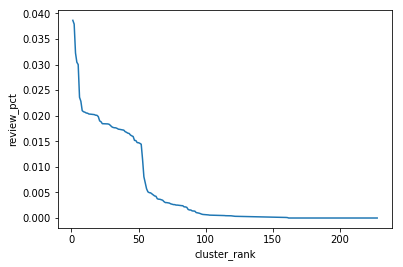

In [95]:
sns.lineplot(y=review_summary['review_pct'],x=review_summary['cluster_rank'])

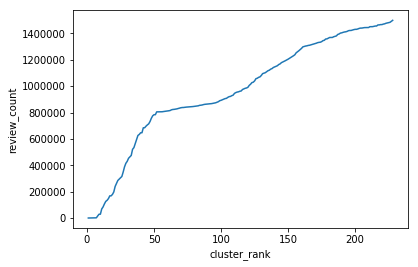

In [96]:
y=review_summary['review_count'].cumsum()
x = review_summary['cluster_rank']
sns.lineplot(y=y,x=x)

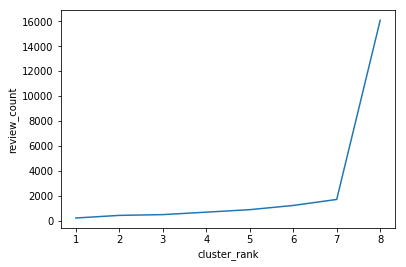

In [97]:
y=review_summary['review_count'].cumsum()[:8]
x = review_summary['cluster_rank'][:8]
sns.lineplot(y=y,x=x)

In [98]:
patient_history_std2.columns

Index([u'age', u'income', u'gender', u'id', u'global_proc_id', u'labels',
       u'REVIEW_FLAG'],
      dtype='object')

In [99]:
review_summary.columns

Index([u'labels', u'review_sum', u'review_count', u'review_pct',
       u'cluster_rank'],
      dtype='object')

In [100]:
# merging review flag summary and patient_history_std2 over cluster labels
patient_cluster_fraud_rank = pd.merge(review_summary[['labels','cluster_rank']],patient_history_std2,on='labels')

In [101]:
patient_cluster_fraud_rank.head(2)

,labels,cluster_rank,age,income,gender,id,global_proc_id,REVIEW_FLAG
0,189,1,-0.383535,-1.363391,-0.906123,736818954,24,0.0
1,189,1,-0.383535,-0.688456,-0.906123,984294061,24,0.0


In [102]:
patient_cluster_fraud_rank.shape

(1499548, 8)

In [103]:
# Merging fraudlent transaction data given and patient_cluster_fraud_rank
patient_history_assoc_review = pd.merge(patient_cluster_fraud_rank,
         fraudulent_transaction,
         how='left',
         on=['id','global_proc_id'])

In [104]:
sorted(patient_history_assoc_review.columns)

['REVIEW_FLAG',
 'age',
 'cluster_rank',
 'count',
 'gender',
 'global_proc_id',
 'id',
 'income',
 'labels']

In [105]:
patient_history_assoc_review.isna().sum()
patient_history_assoc_review.fillna(0,inplace=True)

labels                  0
cluster_rank            0
age                     0
income                  0
gender                  0
id                      0
global_proc_id          0
REVIEW_FLAG             0
count             1484652
dtype: int64

In [106]:
patient_rank = patient_history_assoc_review.groupby('id').agg({'count':'sum','cluster_rank':'mean'}).sort_values(by=['count','cluster_rank'],ascending=[False,True]).reset_index()

In [107]:
patient_rank['patient_rank'] = patient_rank.index+1

In [108]:
patient_rank.head()

,id,count,cluster_rank,patient_rank
0,984836241,10.0,29.0,1
1,151693438,9.0,11.0,2
2,750652657,9.0,21.0,3
3,463925465,9.0,27.0,4
4,712387847,9.0,28.0,5


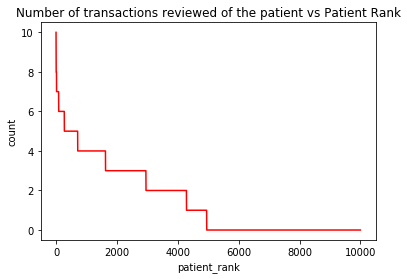

In [109]:
temp = sns.lineplot(x=patient_rank['patient_rank'][:10000],y=patient_rank['count'][:10000],color='r').set_title('Number of transactions reviewed of the patient vs Patient Rank')

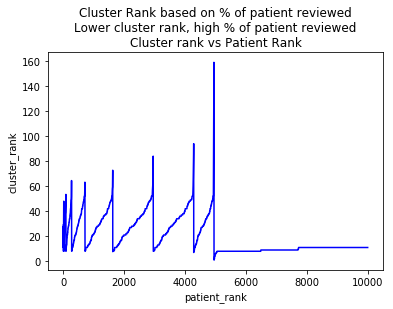

In [110]:
temp = sns.lineplot(x=patient_rank['patient_rank'][:10000],y=(patient_rank['cluster_rank'])[:10000],color='b').set_title('Cluster Rank based on % of patient reviewed\nLower cluster rank, high % of patient reviewed\nCluster rank vs Patient Rank')

In [111]:
patient_rank.to_csv('Patient Ranks.csv')